# Higher-order QAM modulation with QAMPy

QAMpy also has the equalisers for higher-order QAM buildin. In this notebook we demonstrate the equalisation of a 64QAM signal using a dual-mode equaliser consisting of a MCMA and a decision directed algorithm

In [27]:
from qampy import signals, impairments, equalisation, phaserec, helpers
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
output_notebook()

Loading BokehJS ...

These are the same imports as in the QPSK demo. Let us generate something more challenging.

In [28]:
s = signals.ResampledQAM(64, 2**16, fb=40e9, fs=80e9, nmodes=2, resamplekwargs={"beta":0.1, "renormalise":True}) 

/home/jschrod/PycharmProjects/PyCommunication/qampy/core/special_fcts.py:192: RuntimeWarning: invalid value encountered in true_divide
  rrcos = 1/T*((np.sin(np.pi*t/T*(1-beta)) +  4*beta*t/T*np.cos(np.pi*t/T*(1+beta)))/(np.pi*t/T*(1-(4*beta*t/T)**2)))
/home/jschrod/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


The above is a convenience class that allows us to immediately generate a resampled signal

In [29]:
s = impairments.simulate_transmission(s, snr=25, lwdth=1e5, dgd=50e-12, theta=np.pi/5)

This function lets us simulate much of the impairments in one go. Which can be convenient at times. 

In [32]:
def plot_constellation(E):
    fig = figure(title="QPSK signal constellation")#, output_backend="webgl")
    fig.scatter(E[0].real, E[0].imag, color='red', alpha=0.3, legend="X")
    fig.scatter(E[1].real, E[1].imag, color='blue', alpha=0.3, legend="Y")
    fig.xaxis[0].axis_label = "In-Phase"
    fig.yaxis[0].axis_label = "Quadrature"
    show(fig)
    #plt.plot(E[0].real, E[0].imag, 'r.', label="X")
    #plt.plot(E[1].real, E[1].imag, 'b.', label="Y")
    #plt.legend()
    #plt.show()

In [33]:
plot_constellation(s)

## We should use a dual mode equaliser. 

Generally for blind-equalisation of higher-order QAM signals, one uses a dual-mode approach. That is, we use a CMA-type equaliser for the pre-convergence and then a decision directed equaliser in a second step. QAMpy has a number of different algorithms both non-decision and decision based. You can find documentation in the equalisation module.

In [13]:
help(equalisation)

Help on module qampy.equalisation in qampy:

NAME
    qampy.equalisation - Equalisa tion functions the equaliser update functions provided are:

DESCRIPTION
    No decision based:
    -----------------
    Constant Modulus Algorithm (CMA) after _[1]
    Radius Directed Error (RDE) after _[2]
    Modfied Constant Modulus Algorithm (MCMA) after _[3]
    Modified Radius Directed Error (MRDA) after _[7]
    Constellation Matched Error Algorithm (CME) after _[5]
    Square Contour Algorithm (SCA)  after _[6]
    
    Decision Directed
    -----------------
    Symbol Based Decision (SBD) after _[7]
    Modified Decision Directed Modulus Algorithm (MDDMA) after _[8]
    
    Adaptive Step Size Algorithms
    -----------------------------
    based on the step size adoption in _[9]  it is possible to use an adaptive step for all equalisers using the adaptive_stepsize keyword parameter
    
    References
    ----------
    ...[3] Oh, K. N., & Chin, Y. O. (1995). Modified constant modulus algo

## Best ones most of times MCMA and SBD

We have found that most of the times a dual-mode equaliser of MCMA and SBD works best. It is both very accurate and fast. 

In [16]:
sout, wxy, err = equalisation.dual_mode_equalisation(s, (1e-2, 1e-2), 11, methods=("mcma", "sbd"), avoid_cma_sing=(False, False))
sout = helpers.normalise_and_center(sout)

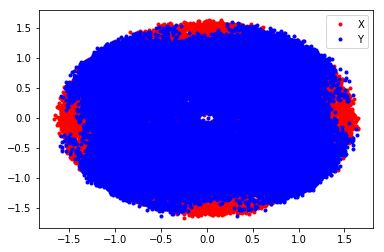

In [17]:
plot_constellation(sout)

## Phase recovery of high-order QAM

Generally speaking the ViterbiViterbi algorithm does not work for QAM signals with M>4. While there are some adjusted algorithms (and some are implemented in QAMpy), the generally accepted approach is to use a blind phase search (BPS) algorithm. 

In [21]:
sout, ph = phaserec.bps(sout, 64, 20)
sout = helpers.normalise_and_center(sout)

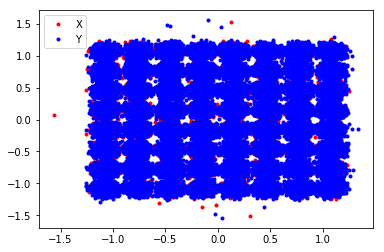

In [22]:
plot_constellation(sout)

## Note this processing is again highly optimized


In [23]:
timeit equalisation.dual_mode_equalisation(s, (1e-2, 1e-2), 11, methods=("mcma", "sbd"), avoid_cma_sing=(False, False))

80.1 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
timeit phaserec.bps(sout, 64, 20)

547 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print(sout.cal_ser())
print(sout.cal_gmi())

/home/jschrod/.local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


[0.00247211 0.01098717]
(array([5.77934081, 5.76395595]), array([[0.93870797, 0.98224929, 0.98685129, 0.89534067, 0.98670429,
        0.9894873 ],
       [0.94169111, 0.97699457, 0.98137215, 0.90360714, 0.98022461,
        0.98006637]]))
